In [3]:
import qiskit as qk
import math
import numpy as np

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from qiskit.providers.aer.noise import NoiseModel, errors
import scipy.linalg as la

In [43]:
def testR(randn,p):
    
    if randn >= p:
        return 0
    elif randn < p/3:
        return 1
    elif randn < 2*p/3:
        return 2
    elif randn < p:
        return 3

def build_pauli_mask(n,basis,p,gatetype):
    
    if gatetype == 'CX':
        if basis == 'X' or basis == 'Y':
            r = np.random.rand(6*n-1)
        else:
            r = np.random.rand(7*n-1)
    else:
        if basis == 'X' or basis == 'Y':
            r = np.random.rand(5*n-1)
        else:
            r = np.random.rand(6*n-1)
        
    for i in range(len(r)):
        r[i] = testR(r[i],p)
    
    return r

def add_pauli(qc,qr,qubit,m):
    
    if m == 0:
        pass
    elif m == 1:
        qc.x(qr[qubit])
    elif m == 2:
        qc.y(qr[qubit])
    elif m == 3:
        qc.z(qr[qubit])
    
    return

def charcterization_sequence(n,p,basis,fgateparams,cname='circuit0',erparams=None):
    
    qr = qk.QuantumRegister(n)
    cr = qk.ClassicalRegister(n)
    circuit = qk.QuantumCircuit(qr,cr,name=cname)
    
    mask = build_pauli_mask(n,basis,p,fgateparams[0])
    
    j = prepareCircuitWithPaulisAndCoherentError(qr,cr,circuit,n,basis,mask,fgateparams,erparams)
 #   print(j)
    
    return circuit
        
def prepareCircuitWithPaulis(qr,cr,qc,n,basis,mask,fgateparams):
    
    j=0
    add_pauli(qc,qr,j,mask[j])
    j += 1
    
    qc.h(qr[0])
    
    for i in range(n):
        add_pauli(qc,qr,i,mask[j])
        j += 1
    
    for i in range(n-1):
        qc.cx(qr[0],qr[i+1])
        add_pauli(qc,qr,0,mask[j])
        j+=1
        add_pauli(qc,qr,i+1,mask[j])
        j+=1
    
    if basis == 'X':
        for i in range(n):
            qc.h(qr[i])
            add_pauli(qc,qr,i,mask[j])
            j+=1
    elif basis == 'Y':
        for i in range(n):
            #qc.u3(math.pi/2,-math.pi/2,math.pi/2,qr[i])
            qc.h(qr[i])
            qc.s(qr[i])
            add_pauli(qc,qr,i,mask[j])
            j+=1
            
    if fgateparams[0] == 'U1':
        for i in range(n):
            qc.u1(-fgateparams[1],qr[i])
            qc.barrier(qr[i])
            qc.u1(fgateparams[1],qr[i])
            add_pauli(qc,qr,i,mask[j-n])
            j+=1
            qc.barrier(qr[i])
            qc.u1(-fgateparams[1],qr[i])
            qc.barrier(qr[i])
            qc.u1(fgateparams[1],qr[i])
    elif fgateparams[0] == 'U2':
        for i in range(n):
            qc.u2(-fgateparams[2]+math.pi,-fgateparams[1]+math.pi,qr[i])
            qc.barrier(qr[i])
            qc.u2(fgateparams[1],fgateparams[2],qr[i])
            add_pauli(qc,qr,i,mask[j-n])
            j+=1
            qc.barrier(qr[i])
            qc.u2(-fgateparams[2]+math.pi,-fgateparams[1]+math.pi,qr[i])
            qc.barrier(qr[i])
            qc.u2(fgateparams[1],fgateparams[2],qr[i])
    elif fgateparams[0] == 'U3':
        for i in range(n):
            qc.u3(fgateparams[1],-fgateparams[3]+math.pi,-fgateparams[2]+math.pi,qr[i])
            qc.barrier(qr[i])
            qc.u3(fgateparams[1],fgateparams[2],fgateparams[3],qr[i]) 
            add_pauli(qc,qr,i,mask[j-n])
            j+=1
            qc.barrier(qr[i])
            qc.u3(fgateparams[1],-fgateparams[3]+math.pi,-fgateparams[2]+math.pi,qr[i])
            qc.barrier(qr[i])
            qc.u3(fgateparams[1],fgateparams[2],fgateparams[3],qr[i])        
    elif fgateparams[0] == 'CX':      # da sistemare
        for i in range(n-1):
            qc.cx(qr[i],qr[i+1])
            add_pauli(qc,qr,i,mask[j])
            j+=1
            add_pauli(qc,qr,i+1,mask[j])
            j+=1
        qc.cx(qr[n-1],qr[0])
        add_pauli(qc,qr,n-1,mask[j])
        j+=1
        add_pauli(qc,qr,0,mask[j])
        j+=1
        
     
    if basis == 'Z':
        for i in range(n):
            add_pauli(qc,qr,i,mask[j])
            j+=1
            qc.h(qr[i])
            add_pauli(qc,qr,i,mask[j])
            j+=1
            qc.measure(qr[i],cr[i])
    else:
        for i in range(n):
            qc.measure(qr[i],cr[i])
            
    return j

def prepareCircuitWithPaulisAndCoherentError(qr,cr,qc,n,basis,mask,fgateparams,erparams):
    
    j=0
    add_pauli(qc,qr,j,mask[j])
    j += 1
    
    sx = np.array([[0,1],[1,0]])
    sy = np.array([[0,-1j],[1j,0]])
    sz = np.array([[1,0],[0,-1]])
    
    re = erparams[0]
    nx = erparams[1]
    ny = erparams[2]
    nz = erparams[3]
    
    cerror = errors.coherent_unitary_error(la.expm(-1j *(sx*nx + sy*ny + sz*nz  )*re[2]*math.pi/64) )

    re2 = erparams[4]
    nx2 = erparams[5]
    ny2 = erparams[6]
    nz2 = erparams[7]
    
    cerror2 = errors.coherent_unitary_error(la.expm(-1j *(sx*nx2 + sy*ny2 + sz*nz2  )*re2[2]*math.pi/64) )
   # cerror2 = errors.coherent_unitary_error(la.expm( 1j *(sx*nx + sy*ny + sz*nz  )*re[2]*math.pi/64) )
    
    qc.h(qr[0])
    
    for i in range(n):
        add_pauli(qc,qr,i,mask[j])
        j += 1
    
    for i in range(n-1):
        qc.cx(qr[0],qr[i+1])
        add_pauli(qc,qr,0,mask[j])
        j+=1
        add_pauli(qc,qr,i+1,mask[j])
        j+=1
    
    if basis == 'X':
        for i in range(n):
            qc.h(qr[i])
            add_pauli(qc,qr,i,mask[j])
            j+=1
    elif basis == 'Y':
        for i in range(n):
            #qc.u3(math.pi/2,-math.pi/2,math.pi/2,qr[i])
            qc.h(qr[i])
            qc.s(qr[i])
            add_pauli(qc,qr,i,mask[j])
            j+=1
            
    if fgateparams[0] == 'U1':
        for i in range(n):
            qc.u1(-fgateparams[1],qr[i])
            qc.append(cerror2, [i])
            qc.barrier(qr[i])
            qc.u1(fgateparams[1],qr[i])
            qc.append(cerror, [i])
            add_pauli(qc,qr,i,mask[j-n])
            j+=1
            qc.barrier(qr[i])
            qc.u1(-fgateparams[1],qr[i])
            qc.append(cerror2, [i])
            qc.barrier(qr[i])
            qc.u1(fgateparams[1],qr[i])
            qc.append(cerror, [i])
    elif fgateparams[0] == 'U2':
        for i in range(n):
            qc.u2(-fgateparams[2]+math.pi,-fgateparams[1]+math.pi,qr[i])
            qc.append(cerror2, [i])
            qc.barrier(qr[i])
            qc.u2(fgateparams[1],fgateparams[2],qr[i])
            qc.append(cerror, [i])
            add_pauli(qc,qr,i,mask[j-n])
            j+=1
            qc.barrier(qr[i])
            qc.u2(-fgateparams[2]+math.pi,-fgateparams[1]+math.pi,qr[i])
            qc.append(cerror2, [i])
            qc.barrier(qr[i])
            qc.u2(fgateparams[1],fgateparams[2],qr[i])
            qc.append(cerror, [i])
    elif fgateparams[0] == 'U3':
        for i in range(n):
            qc.u3(fgateparams[1],-fgateparams[3]+math.pi,-fgateparams[2]+math.pi,qr[i])
            qc.append(cerror2, [i])
            qc.barrier(qr[i])
            qc.u3(fgateparams[1],fgateparams[2],fgateparams[3],qr[i]) 
            qc.append(cerror, [i])
            add_pauli(qc,qr,i,mask[j-n])
            j+=1
            qc.barrier(qr[i])
            qc.u3(fgateparams[1],-fgateparams[3]+math.pi,-fgateparams[2]+math.pi,qr[i])
            qc.append(cerror2, [i])
            qc.barrier(qr[i])
            qc.u3(fgateparams[1],fgateparams[2],fgateparams[3],qr[i])       
            qc.append(cerror, [i])
    elif fgateparams[0] == 'CX':      # da sistemare
        for i in range(n-1):
            qc.cx(qr[i],qr[i+1])
            add_pauli(qc,qr,i,mask[j])
            j+=1
            add_pauli(qc,qr,i+1,mask[j])
            j+=1
        qc.cx(qr[n-1],qr[0])
        add_pauli(qc,qr,n-1,mask[j])
        j+=1
        add_pauli(qc,qr,0,mask[j])
        j+=1
        
     
    if basis == 'Z':
        for i in range(n):
            add_pauli(qc,qr,i,mask[j])
            j+=1
            qc.h(qr[i])
            add_pauli(qc,qr,i,mask[j])
            j+=1
            qc.measure(qr[i],cr[i])
    else:
        for i in range(n):
            qc.measure(qr[i],cr[i])
            
    return j


"""
Count  the  outcome  as  an  error  
if  the  outcome  bit  string  for  a  particular  state  has  odd  parity.
Determine the error rate for each state.
5.  Fit the error rates for differentnfor each basisPto a quadraticaPn2+bPn+cP.
6.  Letθ2=aX+aY+aZandv2P=aP/θ2.  These are the parameters of the coherent error in thechannelCr.
"""

def count_errors(counts):
    errors = 0
    total_counts = sum(counts.values())
    for state in counts:
        sum_bits = sum([int(k) for k in list(state)])
        if sum_bits % 2 == 1:
            errors += counts[state]
    return errors * 1.0 / total_counts


def err_func(x, a, b, c):
    return a * (x ** 2) + b * x + c


def get_coherent_error_params(n, x_err, y_err, z_err):
    px = np.polyfit(n, x_err, 2)
    py = np.polyfit(n, y_err, 2)
    pz = np.polyfit(n, z_err, 2)
    theta_square = px[0] + py[0] + pz[0]
    vx_square = px[0] / theta_square
    vy_square = py[0] / theta_square
    vz_square = pz[0] / theta_square
    print(px)
    print(py)
    print(pz)
    print(vx_square)
    
    return [px, py, pz]
    
def plot_fit(f, popt, xdata, ydata):
    # popt, pcov = curve_fit(f, xdata, ydata)
    #popt = np.polyfit(xdata, ydata, 2)
    plt.subplot()
    plt.title('curve_fit')
    new_ydata = [f(x, *popt) for x in xdata]
    plt.plot(xdata,ydata,'ob',label='errors')
    plt.plot(xdata, new_ydata, 'r-',
             label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
    plt.xlabel('n')
    plt.ylabel('err')
    plt.legend(loc='best')
    plt.show()
    
def plot_fit_errors(f, popt, xdata, ydata, error):
    # popt, pcov = curve_fit(f, xdata, ydata)
    #popt = np.polyfit(xdata, ydata, 2)
    plt.subplot()
    plt.title('curve_fit')
    new_ydata = [f(x, *popt) for x in xdata]
    plt.errorbar(xdata,ydata,yerr=error,marker='o',color='b',label='errors')
    plt.plot(xdata, new_ydata, 'r-',
             label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
    plt.xlabel('n')
    plt.ylabel('err')
    plt.legend(loc='best')
    plt.show()
    
def plot_fits(f, popts, xdata, ydatas):
    
    for i in range(3):
        plot_fit(f,popts[i],xdata,ydatas[:,i])
    
def plot_fits_errors(f, popts, xdata, ydatas, errors):
    
    for i in range(3):
        plot_fit_errors(f,popts[i],xdata,ydatas[:,i],errors[:,i])
    
def main(ns,fgateparams,p,n_pauli):
    
    simulator = qk.Aer.get_backend('qasm_simulator')
    
    re = np.random.rand(3)
    nx = math.sin(re[0]*math.pi)*math.cos(re[1]*2*math.pi)
    ny = math.sin(re[0]*math.pi)*math.sin(re[1]*2*math.pi)
    nz = math.cos(re[0]*math.pi)
    print(re[0]*math.pi,re[1]*2*math.pi,re[2]*math.pi/32)
    
    re2 = np.random.rand(3)
    nx2 = math.sin(re2[0]*math.pi)*math.cos(re2[1]*2*math.pi)
    ny2 = math.sin(re2[0]*math.pi)*math.sin(re2[1]*2*math.pi)
    nz2 = math.cos(re2[0]*math.pi)
    print(re2[0]*math.pi,re2[1]*2*math.pi,re2[2]*math.pi/32)
    
    erparams = [re,nx,ny,nz,re2,nx2,ny2,nz2]

    err_avg = np.zeros((ns-1,3))
    err_std = np.zeros((ns-1,3))
    for n in range(2,ns+1):
        j=0
        for b in ['X','Y','Z']:
            error_rate = np.zeros(n_pauli)
            for k in range(n_pauli):
                circ = charcterization_sequence(n,p,b,fgateparams,cname='circuit0',erparams=erparams)
                
                job = qk.execute(circ, simulator, shots=8192)
                result = job.result()
                counts = result.get_counts(circ)
                
                error_rate[k] = count_errors(counts)
                
            err_avg[n-2,j] = np.mean(error_rate)
            err_std[n-2,j] = np.std(error_rate)
            j+=1
            
        print(n)
        
    plist = get_coherent_error_params(np.arange(2,ns+1), err_avg[:,0], err_avg[:,1], err_avg[:,2])
    
    return err_avg, err_std, plist, erparams



In [39]:
err,std,plist,erparams = main(10,['U2',0,math.pi],0.002,100)

0.7019034631697741 5.214835524980864 0.05316807216161764
1.1860755106040002 1.3898327233360432 0.09015226346373903
2
3
4
5
6
7
8
9
10
[ 0.00019465  0.03146363 -0.02345033]
[ 0.00057069  0.08492639 -0.12434284]
[-0.00046119  0.04989768 -0.05717778]
0.639985926260546


0.027664681827562522 [0.02193448 0.08148181 0.05316807]
0.5043085445871474 0.31093718264669745
0.863523532890907 -0.5658717836691909


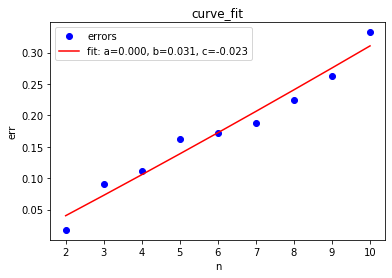

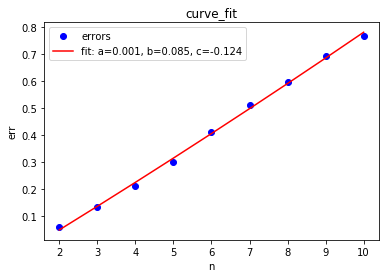

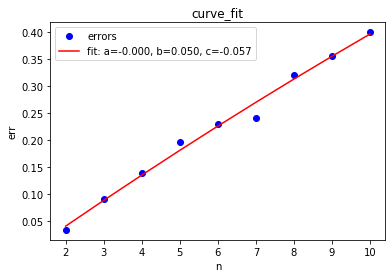

In [42]:
theta2 = plist[0][0]+plist[1][0]+plist[2][0]*0
print(math.sqrt(theta2),erparams[0]*math.pi/32)
print(math.sqrt(plist[0][0]/theta2),erparams[1])
print(math.sqrt(plist[1][0]/theta2),erparams[2])
#print(math.sqrt(plist[2][0]/theta2),erparams[3])

plot_fits(err_func, plist, np.arange(2,11), err)

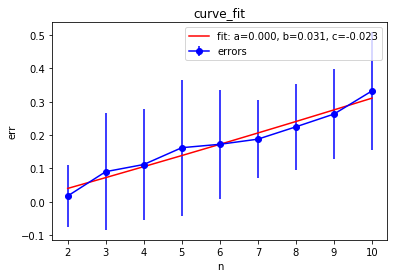

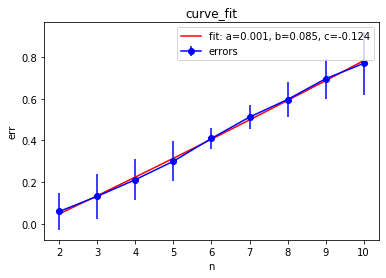

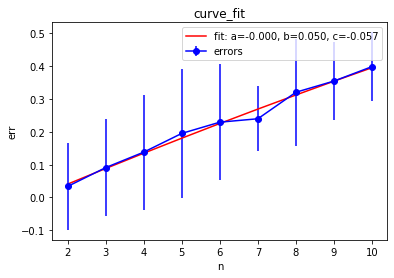

In [44]:
plot_fits_errors(err_func, plist, np.arange(2,11), err, std)

In [30]:
plist[0][1]

-0.002537231533386315

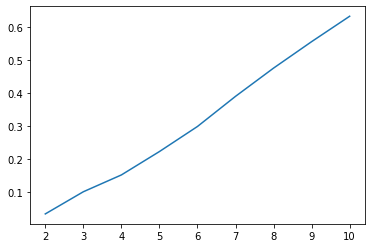

In [13]:
#plt.errorbar(np.arange(2,11),err[:,0],yerr=std[:,0])
plt.plot(np.arange(2,11),err[:,0])

0.6666666666666666